# Theoretical activities of deep linear networks

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/thebuckleylab/jpc/blob/main/examples/linear_net_theoretical_activities.ipynb)

In [1]:
%%capture
!pip install torch==2.3.1
!pip install torchvision==0.18.1
!pip install plotly==5.11.0
!pip install -U kaleido

In [2]:
import jpc

import jax
from jax import vmap
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
import optax

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import plotly.graph_objs as go
import plotly.io as pio

pio.renderers.default = 'iframe'

## Hyperparameters

We define some global parameters, including network architecture, learning rate, batch size etc.

In [3]:
SEED = 0
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
TEST_EVERY = 10
N_TRAIN_ITERS = 20

## Dataset

Some utils to fetch MNIST.

In [4]:
#@title data utils


def get_mnist_loaders(batch_size):
    train_data = MNIST(train=True, normalise=True)
    test_data = MNIST(train=False, normalise=True)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader, test_loader


class MNIST(datasets.MNIST):
    def __init__(self, train, normalise=True, save_dir="data"):
        if normalise:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.1307), std=(0.3081)
                    )
                ]
            )
        else:
            transform = transforms.Compose([transforms.ToTensor()])
        super().__init__(save_dir, download=True, train=train, transform=transform)

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        img = torch.flatten(img)
        label = one_hot(label)
        return img, label


def one_hot(labels, n_classes=10):
    arr = torch.eye(n_classes)
    return arr[labels]
    

## Plotting

In [5]:
def plot_layer_energies(energies):
    n_train_iters = energies["theory"].shape[0]
    n_energies = energies["theory"].shape[1]
    train_iters = [b+1 for b in range(n_train_iters)]
    
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52', '#8C564B']
    
    fig = go.Figure()
    for n in range(n_energies):
        fig.add_traces(
            go.Scatter(
                x=train_iters,
                y=energies["theory"][:, n],
                mode="lines",
                line=dict(
                    width=2, 
                    dash="dash",
                    color=colors[n]
                ),
                showlegend=False
            )
        )
        fig.add_traces(
            go.Scatter(
                x=train_iters,
                y=energies["experiment"][:, n],
                name=f"$\Large{{\ell_{n+1}}}$",
                mode="lines",
                line=dict(
                    width=3, 
                    dash="solid",
                    color=colors[n]
                ),
            )
        )
    
    fig.update_layout(
        height=350,
        width=475,
        xaxis=dict(
            title="Training iteration",
            tickvals=[1, int(train_iters[-1]/2), train_iters[-1]],
            ticktext=[1, int(train_iters[-1]/2), train_iters[-1]],
        ),
        yaxis=dict(
            title="Energy",
            nticks=3
        ),
        font=dict(size=16),
    )
    fig.write_image("dln_layer_energies_example.pdf")
    return fig


## Linear network

In [6]:
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, 21)

network = [
    eqx.nn.Linear(784, 300, key=subkeys[0], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[1], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[2], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[3], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[4], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[5], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[6], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[7], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[8], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[9], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[10], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[11], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[12], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[13], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[14], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[15], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[16], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[17], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[18], use_bias=False),
    eqx.nn.Linear(300, 300, key=subkeys[19], use_bias=False),
    eqx.nn.Linear(300, 10, key=subkeys[20], use_bias=False),
]

## Train and test

A PC network can be trained in a single line of code with `jpc.make_pc_step()`. See the documentation for more. Similarly, we can use `jpc.test_discriminative_pc()` to compute the network accuracy. Note that these functions are already "jitted" for performance.

Below we simply wrap each of these functions in our training and test loops, respectively.

In [7]:
def evaluate(model, test_loader):
    test_acc = 0
    for batch_id, (img_batch, label_batch) in enumerate(test_loader):
        img_batch = img_batch.numpy()
        label_batch = label_batch.numpy()

        test_acc += jpc.test_discriminative_pc(
            model=model,
            y=label_batch,
            x=img_batch
        )

    return test_acc / len(test_loader)


def train(
      model,  
      lr,
      batch_size,
      t1,
      test_every,
      n_train_iters
):
    optim = optax.adam(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loader, test_loader = get_mnist_loaders(batch_size)

    As, cond_numbers = [], []
    num_energies, theory_energies = [], []
    num_total_energies, theory_total_energies = [], []
    for iter, (img_batch, label_batch) in enumerate(train_loader):
        img_batch = img_batch.numpy()
        label_batch = label_batch.numpy()

        theory_total_energies.append(
            jpc.linear_equilib_energy(
                network=model, 
                x=img_batch, 
                y=label_batch
            )
        )
        A = jpc.linear_activities_coeff_matrix([l.weight for l in model])
        As.append(A)
        cond_numbers.append(jnp.linalg.cond(A))
        theory_activities = jpc.linear_activities_solution(
            network=model, 
            x=img_batch, 
            y=label_batch
        )
        theory_energies.append(
            jnp.flip(jpc.pc_energy_fn(
                model,
                theory_activities,
                x=img_batch,
                y=label_batch,
                record_layers=True
            ))
        )
        result = jpc.make_pc_step(
            model,
            optim,
            opt_state,
            y=label_batch,
            x=img_batch,
            t1=t1,
            record_energies=True
        )
        model, optim, opt_state = result["model"], result["optim"], result["opt_state"]
        train_loss, t_max = result["loss"], result["t_max"]
        num_total_energies.append(result["energies"][:, t_max-1].sum())
        num_energies.append(result["energies"][:, t_max-1])

        if ((iter+1) % test_every) == 0:
            avg_test_acc = evaluate(model, test_loader)
            print(
                f"Train iter {iter+1}, train loss={train_loss:4f}, "
                f"avg test accuracy={avg_test_acc:4f}"
            )
            if (iter+1) >= n_train_iters:
                break

    return {
        "experiment": jnp.array(num_energies),
        "theory": jnp.array(theory_energies)
    }, As, cond_numbers


## Run

In [8]:
energies, As, cond_numbers = train(
    model=network,
    lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    t1=300,
    test_every=TEST_EVERY,
    n_train_iters=N_TRAIN_ITERS
)

/Users/fi69/PycharmProjects/jpc/venv/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning:

unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.



Train iter 10, train loss=0.091816, avg test accuracy=0.270333
Train iter 20, train loss=0.089849, avg test accuracy=0.335337


In [9]:
import matplotlib.pyplot as plt

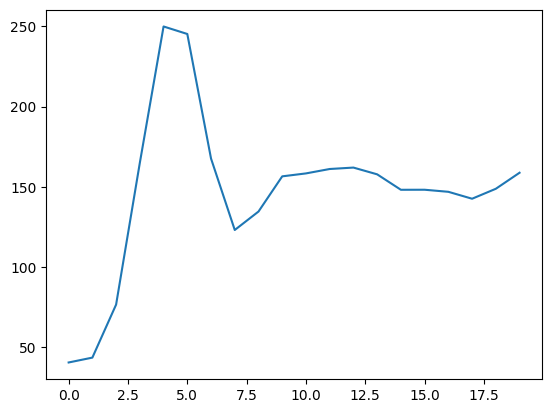

In [10]:
plt.plot(cond_numbers)

In [12]:
n_train_iters = energies["theory"].shape[0]
n_energies = energies["theory"].shape[1]
train_iters = [b+1 for b in range(n_train_iters)]

colors = [
    '#636EFA', 
    '#EF553B',
    '#00CC96', 
    '#AB63FA', 
    '#FFA15A', 
    '#19D3F3', 
    '#FF6692', 
    '#B6E880', 
    '#FF97FF', 
    '#FECB52', 
    '#8C564B',
    '#636EFA', 
    '#EF553B',
    '#00CC96', 
    '#AB63FA', 
    '#FFA15A', 
    '#19D3F3', 
    '#FF6692', 
    '#B6E880', 
    '#FF97FF', 
    '#FECB52', 
    '#8C564B',
    '#636EFA', 
    '#EF553B',
    '#00CC96', 
    '#AB63FA', 
    '#FFA15A', 
    '#19D3F3', 
    '#FF6692', 
    '#B6E880', 
    '#FF97FF', 
    '#FECB52', 
    '#8C564B'
]

fig = go.Figure()
for n in range(n_energies):
    fig.add_traces(
        go.Scatter(
            x=train_iters,
            y=energies["theory"][:, n],
            mode="lines",
            line=dict(
                width=3, 
                dash="dash",
                color=colors[n]
            ),
            showlegend=False
        )
    )
    fig.add_traces(
        go.Scatter(
            x=train_iters,
            y=energies["experiment"][:, n],
            name=f"$\Large{{\ell_{{{n+1}}}}}$",
            mode="lines",
            line=dict(
                width=2, 
                dash="solid",
                color=colors[n]
            ),
        )
    )

fig.update_layout(
    height=400,
    width=600,
    xaxis=dict(
        title="Training iteration",
        tickvals=[1, int(train_iters[-1]/2), train_iters[-1]],
        ticktext=[1, int(train_iters[-1]/2), train_iters[-1]],
    ),
    yaxis=dict(
        title="Energy",
        nticks=3
    ),
    font=dict(size=16)
)